# Combine Downloads

In [10]:
import pandas as pd

files = [
    "./raw_data/year_xrp_historical_data_1m.csv",
    "./raw_data/20_22_xrp_historical_data_1m.csv",
]
df = pd.DataFrame()
for file in files:
    data = pd.read_csv(file)
    df = pd.concat([df, data], axis=0)
    df = df.drop_duplicates()
    df = df.sort_values("timestamp")
    df["symbol"] = "XRP/USDT"
df.to_csv("20_23_xrp_historical_data_1m.csv", index=False)

# Check missing values

In [11]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = "./20_23_xrp_historical_data_1m.csv"
df = pd.read_csv(file_path)

# Convert the 'timestamp' column to pandas DateTime type
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort the DataFrame by 'timestamp'
df = df.sort_values("timestamp")
# df = df.drop_duplicates()
# df.to_csv("20_23_eth_historical_data_1m.csv", index=False)

# Calculate the time differences between consecutive timestamps
df["time_diff"] = df["timestamp"].diff()

# Filter out rows where the time difference is not equal to 1 minute
missing_intervals_df = df[df["time_diff"] != pd.Timedelta(minutes=1)]
missing_intervals_df

,timestamp,open,high,low,close,volume,symbol,time_diff
0,2020-09-01 00:00:00,0.28115,0.28139,0.28072,0.28131,212639.60,XRP/USDT,NaT
129960,2020-11-30 07:00:00,0.62588,0.62705,0.62533,0.62654,454736.50,XRP/USDT,0 days 01:01:00
160608,2020-12-21 18:00:00,0.52254,0.52393,0.51717,0.51985,974013.50,XRP/USDT,0 days 04:13:00
165408,2020-12-25 03:00:00,0.34891,0.34892,0.34124,0.34231,1385972.10,XRP/USDT,0 days 01:01:00
234569,2021-02-11 05:00:00,0.51164,0.51186,0.51026,0.51031,751892.50,XRP/USDT,0 days 01:20:00
267509,2021-03-06 03:30:00,0.45720,0.46680,0.45701,0.46676,2648050.70,XRP/USDT,0 days 01:31:00
332219,2021-04-20 04:30:00,1.24414,1.27979,1.24224,1.26446,2324990.40,XRP/USDT,0 days 02:31:00
339391,2021-04-25 08:45:00,1.04587,1.04777,1.03890,1.04590,632771.50,XRP/USDT,0 days 04:44:00
497386,2021-08-13 06:30:00,0.97830,0.99850,0.97810,0.99840,2063132.76,XRP/USDT,0 days 04:31:00
565096,2021-09-29 09:00:00,0.92490,0.92500,0.91800,0.91800,377686.00,XRP/USDT,0 days 02:01:00


In [18]:
import ccxt
import pandas as pd


def fetch_binance_ohlcv(symbol, timeframe, since, limit):
    binance = ccxt.binance()
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, since, limit)
    return [x[0:6] for x in ohlcv]  # Only select timestamp and OHLCV data


# Load the CSV file into a DataFrame
file_path = "./raw_data/20_23_btc_historical_data_1m.csv"
df = pd.read_csv(file_path)

# Convert the 'timestamp' column to pandas DateTime type
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort the DataFrame by 'timestamp'
df = df.sort_values("timestamp")

# Calculate the time differences between consecutive timestamps
df["time_diff"] = df["timestamp"].diff()

# Filter out rows where the time difference is not equal to 1 minute
missing_intervals_df = df[df["time_diff"] != pd.Timedelta(minutes=1)]

# Initialize an empty DataFrame to store missing data
missing_data_df = pd.DataFrame(
    columns=["timestamp", "open", "high", "low", "close", "volume"]
)

# Iterate over missing intervals to fetch missing data
for idx, row in missing_intervals_df.iterrows():
    if pd.isna(row["time_diff"]):  # Skip the first row
        continue

    missing_minutes = (
        int(row["time_diff"].total_seconds() // 60) - 1
    )  # -1 to exclude the current minute
    if missing_minutes > 0:
        since = int(
            (row["timestamp"] - pd.Timedelta(minutes=missing_minutes)).timestamp()
            * 1000
        )
        ohlcv_data = fetch_binance_ohlcv("BTC/USDT", "1m", since, missing_minutes)

        # Convert fetched data to DataFrame
        temp_df = pd.DataFrame(
            ohlcv_data, columns=["timestamp", "open", "high", "low", "close", "volume"]
        )
        temp_df["timestamp"] = pd.to_datetime(temp_df["timestamp"], unit="ms")

        # Append the fetched data to the missing_data_df
        missing_data_df = pd.concat([missing_data_df, temp_df])

missing_data_df.to_csv("./missing_values/btc_values.csv", index=False)

# Calculating returns column

In [1]:
import pandas as pd

In [32]:
# 1m return
data = pd.read_csv("./raw_data/20_23_btc_historical_data_1m.csv")
data.drop_duplicates(inplace=True)

data["return"] = data["close"].pct_change()

new_file_path = "./data_with_returns/20_23_btc_historical_data_returns.csv"
data.to_csv(new_file_path, index=False)

In [ ]:
# 5m return
# Convert the 'timestamp' column to pandas datetime object
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Set the 'timestamp' column as the index
data.set_index("timestamp", inplace=True)

# Resample the data to 5-minute intervals, taking the 'close' price at each interval
data_5min = data["close"].resample("5T").last()

# Calculate the returns for these 5-minute intervals
data_5min_return = data_5min.pct_change()

# Drop NaN values for accurate calculation and plotting
data_5min_return = data_5min_return.dropna()

# Preview the data
data_5min_return.head()


# Finding Maximum Drawdowns / Spikes

In [1]:
import pandas as pd

In [2]:
# Load the data from the CSV file again
file_path = "./data_with_returns/20_23_btc_historical_data_returns.csv"
df = pd.read_csv(file_path)

# Convert 'timestamp' column to datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Show the first few rows of the DataFrame
df.head()

,timestamp,open,high,low,close,volume,symbol,return
0,2020-09-01 00:00:00,11649.51,11664.78,11649.50,11661.93,58.776664,BTC/USDT,NaN
1,2020-09-01 00:01:00,11661.92,11668.18,11660.07,11667.77,71.511145,BTC/USDT,0.000501
2,2020-09-01 00:02:00,11667.77,11668.50,11664.68,11667.12,35.425516,BTC/USDT,-0.000056
3,2020-09-01 00:03:00,11667.12,11667.72,11655.91,11656.57,44.414383,BTC/USDT,-0.000904
4,2020-09-01 00:04:00,11656.57,11656.57,11634.06,11647.06,125.959861,BTC/USDT,-0.000816


In [3]:
# Calculate the returns
df["return"] = df["close"].pct_change() * 100

# Filter out returns greater than +3% or less than -3%
extreme_returns_df = df[(df["return"] > 3) | (df["return"] < -3)]

# Display the rows with returns greater than +3% or less than -3%
extreme_returns_df


,timestamp,open,high,low,close,volume,symbol,return
190563,2021-01-11 14:15:00,31131.36,32302.10,31115.00,32169.54,1135.772717,BTC/USDT,3.334837
250965,2021-02-22 14:16:00,49965.20,49965.21,47818.99,47835.64,1218.319440,BTC/USDT,-4.262106
329433,2021-04-18 03:34:00,54522.00,54669.71,52088.10,52674.66,546.737690,BTC/USDT,-3.384703
374118,2021-05-19 11:33:00,36420.00,37600.00,36333.00,37600.00,994.287723,BTC/USDT,3.262576
374198,2021-05-19 12:53:00,34556.69,34957.26,33410.81,33478.24,1554.536972,BTC/USDT,-3.120814
374202,2021-05-19 12:57:00,33497.04,35261.18,33251.34,35007.72,1021.879170,BTC/USDT,4.629241
374213,2021-05-19 13:08:00,32674.76,32674.76,31337.00,31361.26,1272.637302,BTC/USDT,-3.200072
374214,2021-05-19 13:09:00,31361.26,31450.54,30100.00,30101.00,1416.193856,BTC/USDT,-4.018525
374215,2021-05-19 13:10:00,30101.00,31474.97,30000.00,31392.53,1531.672583,BTC/USDT,4.290655
374226,2021-05-19 13:21:00,35299.52,35552.91,33000.00,33141.61,865.602598,BTC/USDT,-5.798912


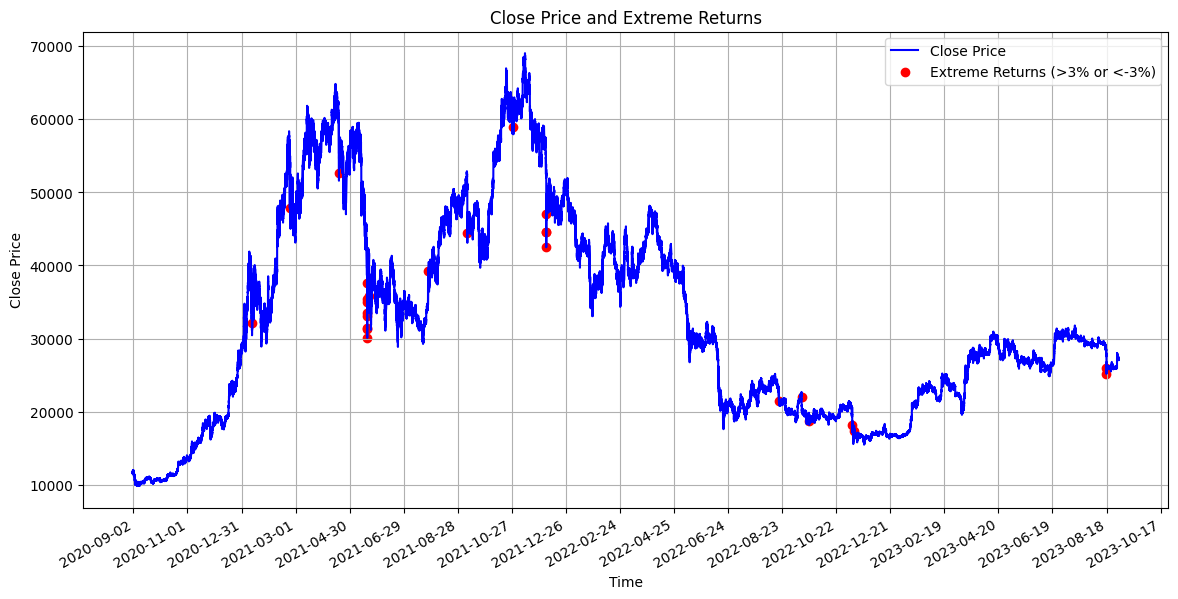

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting
plt.figure(figsize=(14, 7))

# Plot close prices
plt.plot(df["close"], label="Close Price", color="blue")

# Highlight extreme returns
plt.scatter(
    extreme_returns_df.index,
    extreme_returns_df["close"],
    color="red",
    label="Extreme Returns (>3% or <-3%)",
)

# Add title and labels
plt.title("Close Price and Extreme Returns")
plt.xlabel("Time")
plt.ylabel("Close Price")

# Format x-axis to show timestamps more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gcf().autofmt_xdate()

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Calculating max drawdowns/spikes df

In [6]:
import os
import numpy as np
import pandas as pd

files = os.listdir("./raw_data/")

natural_spikes = list()
for x in files:
    print(x)
    df = pd.read_csv(f"./raw_data/{x}")

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["return"] = df["close"].pct_change() * 100
    extreme_returns_df = df[(df["return"] > 3) | (df["return"] < -3)]

    extreme_returns_df["Type"] = np.where(
        extreme_returns_df["return"] > 0, "Spike", "Drawdown"
    )
    natural_spikes.append(extreme_returns_df)
    # df = pd.concat([natural_spikes_df, extreme_returns_df], ignore_index=True)

# Display the rows with returns greater than +3% or less than -3%
natural_spikes_df = pd.concat(natural_spikes)
print(natural_spikes_df.head())

natural_spikes_df.to_csv("./natural_spikes_drawdowns.csv", index=False)


20_23_btc_historical_data_1m.csv


C:\Users\Denis\AppData\Local\Temp\ipykernel_22036\499796144.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_returns_df['Type'] = np.where(extreme_returns_df['return'] > 0, 'Spike', 'Drawdown')


20_23_eth_historical_data_1m.csv


C:\Users\Denis\AppData\Local\Temp\ipykernel_22036\499796144.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_returns_df['Type'] = np.where(extreme_returns_df['return'] > 0, 'Spike', 'Drawdown')


20_23_xrp_historical_data_1m.csv
                 timestamp      open      high       low     close   
190563 2021-01-11 14:15:00  31131.36  32302.10  31115.00  32169.54  \
250965 2021-02-22 14:16:00  49965.20  49965.21  47818.99  47835.64   
329433 2021-04-18 03:34:00  54522.00  54669.71  52088.10  52674.66   
374118 2021-05-19 11:33:00  36420.00  37600.00  36333.00  37600.00   
374198 2021-05-19 12:53:00  34556.69  34957.26  33410.81  33478.24   

             volume    symbol    return      Type  
190563  1135.772717  BTC/USDT  3.334837     Spike  
250965  1218.319440  BTC/USDT -4.262106  Drawdown  
329433   546.737690  BTC/USDT -3.384703  Drawdown  
374118   994.287723  BTC/USDT  3.262576     Spike  
374198  1554.536972  BTC/USDT -3.120814  Drawdown  


C:\Users\Denis\AppData\Local\Temp\ipykernel_22036\499796144.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_returns_df['Type'] = np.where(extreme_returns_df['return'] > 0, 'Spike', 'Drawdown')


# Cool Plots

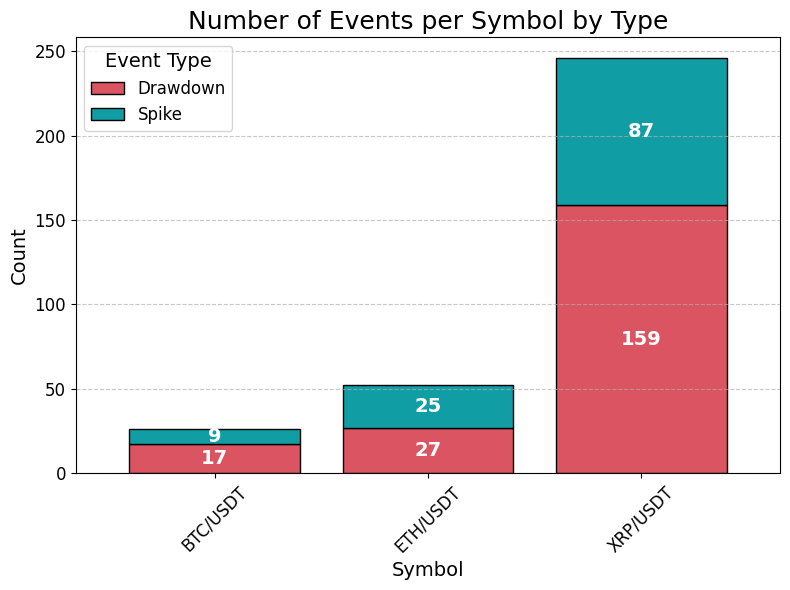

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
data = pd.read_csv("./natural_spikes_drawdowns.csv")

# Count events by type
type_counts = data.groupby("symbol")["Type"].value_counts().unstack().fillna(0)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Use a distinct color palette
colors = ["#DB5461", "#119DA4"]

# Plot the data
type_counts.plot(
    kind="bar", stacked=True, ax=ax, color=colors, edgecolor="black", width=0.8
)

# Set the title, labels, and other aesthetics
ax.set_title("Number of Events per Symbol by Type", fontsize=18)
ax.set_xlabel("Symbol", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Event Type", fontsize=12, title_fontsize=14)

# Annotate the counts on the bar stacks with larger font size
for idx, rect in enumerate(ax.patches):
    y_value = rect.get_y() + rect.get_height() / 2
    count = int(rect.get_height())
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        y_value,
        str(count),
        ha="center",
        va="center",
        fontsize=14,
        color="white",
        weight="bold",
    )

plt.tight_layout()
plt.savefig("./events_per_symbol.png")
plt.show()

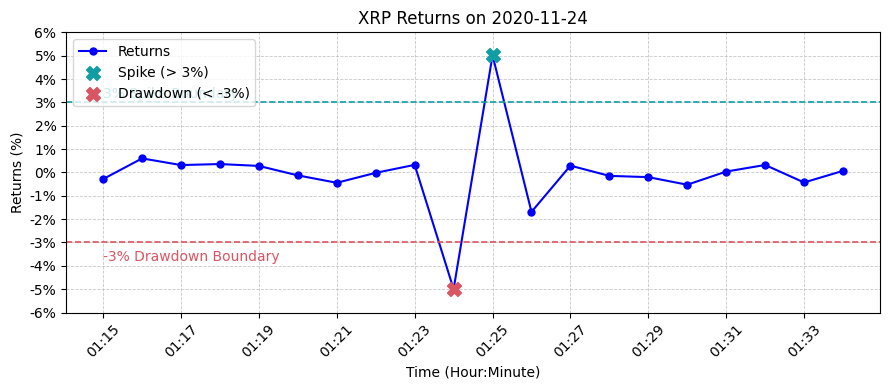

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load the dataset
xrp_data = pd.read_csv("./raw_data/20_23_xrp_historical_data_1m.csv")

# Calculate returns
xrp_data["returns"] = xrp_data["close"].pct_change()

# Filter data for the selected date
selected_date_data = xrp_data[
    pd.to_datetime(xrp_data["timestamp"]).dt.date == datetime.date(2020, 11, 24)
]

# Identify the spikes and drawdowns for the selected date
spikes = selected_date_data[selected_date_data["returns"] > 0.03]
drawdowns = selected_date_data[selected_date_data["returns"] < -0.03]

# Determine the start and end of the timeslot
first_spike_time = spikes["timestamp"].iloc[0]
first_drawdown_time = drawdowns["timestamp"].iloc[0]
start_time = pd.to_datetime(first_spike_time) - pd.Timedelta(minutes=10)
end_time = pd.to_datetime(first_drawdown_time) + pd.Timedelta(minutes=10)

# Filter data for the selected timeslot
timeslot_data = selected_date_data[
    (selected_date_data["timestamp"] >= start_time.strftime("%Y-%m-%d %H:%M:%S"))
    & (selected_date_data["timestamp"] <= end_time.strftime("%Y-%m-%d %H:%M:%S"))
]

# Filter spikes and drawdowns for the selected timeslot
timeslot_spikes = spikes[
    (spikes["timestamp"] >= start_time.strftime("%Y-%m-%d %H:%M:%S"))
    & (spikes["timestamp"] <= end_time.strftime("%Y-%m-%d %H:%M:%S"))
]
timeslot_drawdowns = drawdowns[
    (drawdowns["timestamp"] >= start_time.strftime("%Y-%m-%d %H:%M:%S"))
    & (drawdowns["timestamp"] <= end_time.strftime("%Y-%m-%d %H:%M:%S"))
]

# Convert times to string format for x-axis ticks
times = pd.to_datetime(timeslot_data["timestamp"]).dt.time
time_strings = times.astype(str).str[:-3]  # Removing seconds for clarity

# Plot with y-axis displaying returns in percentages
plt.figure(figsize=(9, 4))
plt.plot(
    timeslot_data["timestamp"],
    timeslot_data["returns"] * 100,
    label="Returns",
    color="blue",
    linewidth=1.5,
    marker="o",
    markersize=5,
)


# Highlighting the spike and drawdown with increased marker size
plt.scatter(
    timeslot_spikes["timestamp"],
    timeslot_spikes["returns"] * 100,
    color="#119DA4",
    label="Spike (> 3%)",
    zorder=5,
    s=100,
    marker="X",
)
plt.scatter(
    timeslot_drawdowns["timestamp"],
    timeslot_drawdowns["returns"] * 100,
    color="#DB5461",
    label="Drawdown (< -3%)",
    zorder=5,
    s=100,
    marker="X",
)

# Enhance the Grid
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)

# Better Labeling - Adjusting the position of the legend
plt.legend(loc="upper left")

# Optimize X-axis Ticks with corrected time strings
plt.xticks(
    timeslot_data["timestamp"][::2], time_strings[::2], rotation=45
)  # Display every second tick for clarity

# Adding horizontal lines for 3% and -3% with increased line width and labels
plt.axhline(y=3, color="#119DA4", linestyle="--", linewidth=1.2)
plt.axhline(y=-3, color="#DB5461", linestyle="--", linewidth=1.2)
plt.text(
    timeslot_data["timestamp"].iloc[0],
    3.2,
    "3% Spike Boundary",
    color="#119DA4",
    fontsize=10,
)
plt.text(
    timeslot_data["timestamp"].iloc[0],
    -3.8,
    "-3% Drawdown Boundary",
    color="#DB5461",
    fontsize=10,
)

# Set Y-axis Limits and Ticks with '%' sign
plt.ylim([-5.5, 5.5])
plt.yticks(ticks=range(-6, 7, 1), labels=[f"{i}%" for i in range(-6, 7, 1)])

# Formatting the plot
plt.title("XRP Returns on 2020-11-24")
plt.xlabel("Time (Hour:Minute)")
plt.ylabel("Returns (%)")
plt.tight_layout()
plt.savefig("xrp_returns.png")
plt.show()

In [ ]:
# Plotting the daily returns along with spikes and drawdowns

# For Bitcoin
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(
    daily_returns_df.index,
    daily_returns_df["Bitcoin"],
    label="Daily Returns",
    marker="o",
)
plt.scatter(
    spikes_btc.index, spikes_btc["Bitcoin"], color="g", label="Spikes", zorder=5
)
plt.scatter(
    drawdowns_btc.index,
    drawdowns_btc["Bitcoin"],
    color="r",
    label="Drawdowns",
    zorder=5,
)
plt.axhline(
    threshold_spike_btc,
    color="g",
    linestyle="--",
    label=f"Spike Threshold ({threshold_spike_btc:.2f}%)",
)
plt.axhline(
    threshold_drawdown_btc,
    color="r",
    linestyle="--",
    label=f"Drawdown Threshold ({threshold_drawdown_btc:.2f}%)",
)
plt.title("Bitcoin: Daily Returns, Spikes, and Drawdowns")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()

# For Ethereum
plt.subplot(1, 2, 2)
plt.plot(
    daily_returns_df.index,
    daily_returns_df["Ethereum"],
    label="Daily Returns",
    marker="o",
)
plt.scatter(
    spikes_eth.index, spikes_eth["Ethereum"], color="g", label="Spikes", zorder=5
)
plt.scatter(
    drawdowns_eth.index,
    drawdowns_eth["Ethereum"],
    color="r",
    label="Drawdowns",
    zorder=5,
)
plt.axhline(
    threshold_spike_eth,
    color="g",
    linestyle="--",
    label=f"Spike Threshold ({threshold_spike_eth:.2f}%)",
)
plt.axhline(
    threshold_drawdown_eth,
    color="r",
    linestyle="--",
    label=f"Drawdown Threshold ({threshold_drawdown_eth:.2f}%)",
)
plt.title("Ethereum: Daily Returns, Spikes, and Drawdowns")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()

plt.tight_layout()
plt.show()
